In [ ]:
import os
os.environ['PYSPARK_PYTHON'] = '/home/hduser/anaconda3/bin/python'

In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, split
from pyspark.sql.types import StringType, ArrayType
from file_parsers import parse_badges, parse_posts, parse_comments, parse_users,\
    parse_posthistory, parse_postlinks, parse_votes, parse_tags

In [ ]:
spark = SparkSession.builder \
    .appName('StackExchange') \
    .master('local[*]') \
    .getOrCreate()
sc = spark.sparkContext
#sc.addPyFile('parser_utils.py')

# Data Loading

In [ ]:
# stack = '/home/piotr/big_data/archive.org/download/stackexchange/'
# #subject = 'meta.stackoverflow.com/'
# subject = 'gardening.stackexchange.com/'
path = 'file:///home/hduser/StackOverflowDump/extracted/'#stack + subject

In [ ]:
badges = parse_badges(sc, path + 'Badges.xml')
posts = parse_posts(sc, path + 'Posts.xml')
comments = parse_comments(sc, path + 'Comments.xml')
users = parse_users(sc, path + 'Users.xml')
posthistory = parse_posthistory(sc, path + 'PostHistory.xml')
postlinks = parse_postlinks(sc, path + 'PostLinks.xml')
votes = parse_votes(sc, path + 'Votes.xml')
tags = parse_tags(sc, path + 'Tags.xml')

# Data Exploration

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
posts.printSchema()

In [ ]:
posts.head(2)

In [8]:
votes.printSchema()

root
 |-- Id: float (nullable = true)
 |-- PostId: float (nullable = true)
 |-- VoteTypeId: float (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- UserId: float (nullable = true)
 |-- BountyAmount: float (nullable = true)



In [32]:
users.printSchema()

root
 |-- Id: float (nullable = true)
 |-- Reputation: float (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- DisplayName: string (nullable = true)
 |-- LastAccessDate: string (nullable = true)
 |-- WebsiteUrl: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- AboutMe: string (nullable = true)
 |-- Views: float (nullable = true)
 |-- UpVotes: float (nullable = true)
 |-- DownVotes: float (nullable = true)
 |-- EmailHash: string (nullable = true)
 |-- Age: float (nullable = true)



## Most popular subjects

In [36]:
most_frequent = tags.filter(col('Count')!=0).sort('Count', ascending=False).limit(20).toPandas()

In [34]:
tags.filter(col('Count')!=0).sort('Count', ascending=False).head(20)

[Row(Id=3.0, TagName='javascript', Count=1769208.0, ExcerptPostId=3624960.0, WikiPostId=3607052.0),
 Row(Id=17.0, TagName='java', Count=1519552.0, ExcerptPostId=3624966.0, WikiPostId=3607018.0),
 Row(Id=9.0, TagName='c#', Count=1289429.0, ExcerptPostId=3624962.0, WikiPostId=3607007.0),
 Row(Id=5.0, TagName='php', Count=1265522.0, ExcerptPostId=3624936.0, WikiPostId=3607050.0),
 Row(Id=1386.0, TagName='android', Count=1176225.0, ExcerptPostId=3625001.0, WikiPostId=3607484.0),
 Row(Id=16.0, TagName='python', Count=1120872.0, ExcerptPostId=3624965.0, WikiPostId=3607014.0),
 Row(Id=820.0, TagName='jquery', Count=945635.0, ExcerptPostId=3625262.0, WikiPostId=3607053.0),
 Row(Id=2.0, TagName='html', Count=806983.0, ExcerptPostId=3673183.0, WikiPostId=3673182.0),
 Row(Id=10.0, TagName='c++', Count=606864.0, ExcerptPostId=3624963.0, WikiPostId=3606997.0),
 Row(Id=58338.0, TagName='ios', Count=591950.0, ExcerptPostId=4536664.0, WikiPostId=4536663.0),
 Row(Id=4.0, TagName='css', Count=575590.0, 

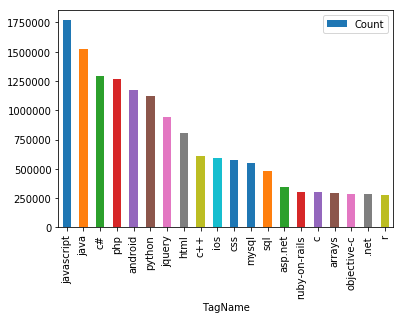

In [37]:
most_frequent.plot.bar(y='Count', x='TagName')

In [46]:
def split_tags_python(tags):
    try:
        l = list(map(lambda x: x[1:], tags.split('>')))
        return l[:-1] #if set(l).intersection(languages) else None
    except AttributeError:
        return None
split_tags = udf(split_tags_python, ArrayType(StringType()))
interesting_tags = posts.select(split_tags('Tags').alias('new_tags'))

In [47]:
interesting_tags.head(10)

[Row(new_tags=['c#', 'floating-point', 'type-conversion', 'double', 'decimal']),
 Row(new_tags=['html', 'css', 'css3', 'internet-explorer-7']),
 Row(new_tags=None),
 Row(new_tags=['c#', '.net', 'datetime']),
 Row(new_tags=['c#', 'datetime', 'time', 'datediff', 'relative-time-span']),
 Row(new_tags=None),
 Row(new_tags=['html', 'browser', 'timezone', 'user-agent', 'timezone-offset']),
 Row(new_tags=['.net', 'math']),
 Row(new_tags=['c#', 'linq', 'web-services', '.net-3.5']),
 Row(new_tags=['mysql', 'database', 'binary-data', 'data-storage'])]

In [26]:
interesting_tags.where(col("new_tags").isNotNull()).count()

KeyboardInterrupt: 

# Posts

In [ ]:
posts_filtered = posts.select(col('Id').cast('integer'), \
                             col('PostTypeId').cast('integer'), \
                             col('ParentId').cast('integer'), \
                             col('CreationDate').cast('timestamp'),
                             col('AnswerCount').cast('integer'))

In [ ]:
posts_filtered.head(3)

In [ ]:
posts_filtered.groupBy('PostTypeId').count().show()

## ile pytań bez odpowiedzi

In [ ]:
posts_filtered.filter(col('AnswerCount')==0).count()

## rozkład czasu pierwszej odpowiedzi

In [ ]:
questions = posts_filtered.filter(col('PostTypeId')==1)
answers = posts_filtered.filter(col('PostTypeId')==2)

In [ ]:
questions.show(5)

In [ ]:
answers.show(5)

In [ ]:
from pyspark.sql import functions as F
first_answers = answers.groupBy('ParentId').agg(F.min(answers.CreationDate))
first_answers.show(5)

In [ ]:
#cos aliasami
from pyspark.sql.functions import unix_timestamp
df_as1 = questions.alias("questions")
df_as2 = first_answers.alias("first_answers")
joined = df_as1.join(df_as2, col("questions.Id") == col("first_answers.ParentId"), 'inner')
questions_time = joined.select(col('Id'), col('CreationDate'), col('min(CreationDate)'))
diff = questions_time.withColumn('diff', (unix_timestamp(col('min(CreationDate)'))-unix_timestamp(col('CreationDate')))/60)
first_answer_time = diff.select(col('Id'), col('diff'))
first_answer_time_pandas = first_answer_time.toPandas()

In [ ]:
first_answer_time_pandas[first_answer_time_pandas['diff']<1]['diff']

In [ ]:
#rozklad czasu od pytania do pierwszej odpowiedzi (ograniczony do pierwszej doby)
sns.boxplot(first_answer_time_pandas[first_answer_time_pandas['diff']<60*24]['diff'])


In [ ]:
#df_as1.join(df_as2, df_as1['Id'] == df_as2['ParentId'], 'inner').show()

In [ ]:
df_as2

# Data Exploration

## Badges

In [ ]:
tags.take(2)

In [ ]:
tags.sort('Count', ascending=False).show()

In [ ]:
import matplotlib
%matplotlib inline

In [ ]:
posts_time = posts.select([col('CreationDate').cast('date'), col('AnswerCount'), col('CommentCount')])

In [ ]:
posts_time.take(2)

In [ ]:
from pyspark.sql.functions import month, year
bitcoin_popularity = posts_time.groupBy(year('CreationDate')).count().toPandas()

In [ ]:
bitcoin_popularity.cumsum().plot()